<a href="https://colab.research.google.com/github/TamimSaykat/Advanced-machine-learning-projects-on-structured-CSV-data/blob/main/Detect_Malicious_activity_in_an_IoT_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# IoT Network Intrusion Detection Project

## Project Overview

This project demonstrates a machine learning approach to detect malicious activity in an IoT network dataset.

### Example :

Suppose you have an **IoT temperature sensor** in a smart home. Normally, it sends readings between 25 °C to 26 °C every minute.

But if a hacker performs **packet spoofing** and forces the sensor to report **50 °C**, that is considered **malicious activity**.

➡️ The intrusion detection system will notice:

* The incoming data (50 °C) is outside the normal range.
* The source of the packet (IP/MAC) is not authentic.
* Therefore, it flags the activity as **suspicious or malicious** and may issue a warning.

---




 The dataset (called **wustliot.csv**) contains about 16,318 records of IoT network traffic combined with sensor readings (e.g. temperature, heart rate, etc.), each labeled as **normal** or one of two attack categories: **Data Alteration** or **Spoofing**. The goal is to build classifiers that can distinguish normal behavior from these attacks. The Jupyter Notebook walks through data preprocessing, feature selection, model training, and evaluation of multiple algorithms for this intrusion detection task.

## Data Preprocessing

Several preprocessing steps were applied to prepare the data for modeling:

* **Data Cleaning:** Null entries were dropped and obvious outliers in numeric features were capped (replaced with mean values) to prevent skewing the models.
* **Categorical Encoding:** Categorical identifiers such as IP addresses, MAC addresses, and port numbers were label-encoded into numeric values so they can be used by the algorithms.
* **Feature Reduction:** An initial ANOVA F-test (`f_classif`) identified and removed features with no significant distinction between attack vs. normal classes (e.g. certain packet loss metrics that were constant or irrelevant). This reduced the feature set from \~42 down to 37 features (plus the target label).
* **Feature Selection:** Using mutual information scores, the top 12 most informative features were selected for modeling. These top features included network traffic metrics like packet number, source/destination jitter, inter-packet intervals, throughput (load/rate), etc., which had the highest predictive value for the attack classes. All other less informative features were dropped, resulting in a final dataset with 12 features plus the target label.

After these steps, the cleaned and reduced dataset was split into training and testing subsets (80% train, 20% test). The training set initially showed class imbalance (the **normal** class far outnumbered the two attack classes), which needed to be addressed before model training.

## Handling Imbalance and Feature Scaling

To ensure the classifiers receive a balanced view of all classes, **SMOTE** (Synthetic Minority Oversampling Technique) was used on the training data. SMOTE generates synthetic examples of the minority classes (Data Alteration and Spoofing) to match the number of normal instances. This oversampling step expanded the training set and equalized the class counts, preventing the models from simply always predicting the majority class.

After balancing, features were standardized using **StandardScaler**. The scaler was fit on the training data and then applied to both the training and test sets, so that all feature values are on a comparable scale (mean 0, unit variance). This scaling is important for certain algorithms (like k-NN, SVM, and neural networks) to perform optimally.

## Model Training and Evaluation

With the data preprocessed, the project trains and evaluates a suite of machine learning classifiers on the balanced training set. The following models were implemented using scikit-learn (and related libraries):

* **Decision Tree** – a tree-based classifier with depth limiting and splitting criteria.
* **Extra Trees** – an ensemble of randomized decision trees for more robust learning.
* **k-Nearest Neighbors (KNN)** – a distance-based classifier (using 7 neighbors, distance weighting).
* **Multilayer Perceptron (MLP)** – a feed-forward neural network (single hidden layer, 128 neurons, trained with the Adam optimizer).
* **Support Vector Classifier (SVC)** – an SVM with RBF kernel for nonlinear separation.
* **CatBoost** – gradient boosting decision trees from the CatBoost library (used with 300 iterations).
* **XGBoost** – gradient boosted trees from the XGBoost library (300 estimators, with tuned subsample and colsample parameters).

Each model was trained on the oversampled training data and optimized with a fixed set of hyperparameters (as defined in the notebook). Training time was recorded for each model to give a sense of efficiency.

After training, the models were evaluated on the hold-out **test set** (which was not oversampled and retained the original class distribution). For each classifier, the notebook produces:

* **Classification Report:** Precision, recall, and F1-score for each class (Data Alteration, Spoofing, Normal) as well as overall accuracy. This provides insight into how well each attack type is being identified.
* **Confusion Matrix:** A matrix showing correct and incorrect predictions for each class, highlighting any misclassification between normal and the two attack categories.
* **ROC Curves:** One-vs-rest Receiver Operating Characteristic curves for each class, along with the calculated macro-average ROC AUC, to visualize the true positive vs. false positive trade-off.
* **Precision-Recall Curves:** For each class, plotting precision vs. recall, along with the Average Precision (AP) score, to evaluate performance on the imbalanced classes more informatively than accuracy.

All models in this project achieved very high performance on the test set. In fact, the classifiers were able to separate the classes with near-perfect accuracy (the Decision Tree, for example, achieved 100% precision and recall in each class on the test data, with a perfect confusion matrix). The ROC AUC and PR AUC scores were correspondingly high (often close to 1.0), indicating excellent detection capabilities for both types of attacks as well as normal traffic. These results suggest that the selected features and models successfully captured the patterns distinguishing normal IoT behavior from spoofing and data alteration attacks.

## Conclusion

In summary, this notebook covers the end-to-end process of building an IoT intrusion detection system using machine learning. It starts from raw data and performs cleaning, encoding, and feature selection to focus on the most relevant indicators of attacks. Through class rebalancing and rigorous model training with various algorithms, it demonstrates how to achieve accurate classification of IoT network intrusions. The evaluation metrics and plots confirm that the models can reliably detect the two attack scenarios in the data. This project provides a clear example of applying data science and machine learning techniques to a cybersecurity problem in the IoT domain, and the notebook serves as a reference for each step from data preprocessing to final model validation.


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [9]:
import pandas as pd

file_id = "1BMQCD3zNfcDHNsYt0zT-zGh1EL5Pdy4T"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

df = pd.read_csv(url)
print(df.head())


     Dir        Flgs     SrcAddr     DstAddr  Sport  Dport  SrcBytes  \
0     ->   e          10.0.1.172  10.0.1.150  58059   1111       496   
1     ->   e          10.0.1.172  10.0.1.150  58062   1111       496   
2     ->   e          10.0.1.172  10.0.1.150  58065   1111       496   
3     ->   e          10.0.1.172  10.0.1.150  58067   1111       496   
4     ->   e          10.0.1.172  10.0.1.150  58069   1111       496   

   DstBytes   SrcLoad  DstLoad  ...  Temp  SpO2  Pulse_Rate  SYS  DIA  \
0       186  276914.0  92305.0  ...  28.9     0           0    0    0   
1       186  230984.0  76995.0  ...  28.9     0           0    0    0   
2       186  218470.0  72823.0  ...  28.9    89         104    0    0   
3       186  203376.0  67792.0  ...  28.9    89         104    0    0   
4       186  235723.0  78574.0  ...  28.9    89         101    0    0   

   Heart_rate  Resp_Rate   ST  Attack Category  Label  
0           0          0  0.0           normal      0  
1          78   

In [10]:
df

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Attack Category,Label
0,->,e,10.0.1.172,10.0.1.150,58059,1111,496,186,276914.0,92305.0,...,28.9,0,0,0,0,0,0,0.0,normal,0
1,->,e,10.0.1.172,10.0.1.150,58062,1111,496,186,230984.0,76995.0,...,28.9,0,0,0,0,78,17,0.4,normal,0
2,->,e,10.0.1.172,10.0.1.150,58065,1111,496,186,218470.0,72823.0,...,28.9,89,104,0,0,78,17,0.4,normal,0
3,->,e,10.0.1.172,10.0.1.150,58067,1111,496,186,203376.0,67792.0,...,28.9,89,104,0,0,79,17,0.4,normal,0
4,->,e,10.0.1.172,10.0.1.150,58069,1111,496,186,235723.0,78574.0,...,28.9,89,101,0,0,79,17,0.4,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,->,e,10.0.1.172,10.0.1.150,57348,1111,496,186,205128.0,68376.0,...,27.7,98,73,148,84,73,19,0.3,normal,0
16314,->,e,10.0.1.172,10.0.1.150,63265,1111,496,186,274058.0,91353.0,...,27.7,98,73,148,84,73,19,0.3,normal,0
16315,->,e,10.0.1.172,10.0.1.150,63918,1111,496,186,288568.0,96189.0,...,23.6,98,73,148,84,73,19,0.3,normal,0
16316,->,e,10.0.1.172,10.0.1.150,52345,1111,496,186,237795.0,79265.0,...,27.4,98,73,148,84,73,19,0.3,normal,0


In [11]:
df.drop(columns=['Label','Dir','Flgs'], inplace=True)


**# Save the training and testing sets to separate CSV files**

In [12]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [13]:
categorical_features

['SrcAddr', 'DstAddr', 'Sport', 'SrcMac', 'DstMac', 'Attack Category']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16318 entries, 0 to 16317
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SrcAddr          16318 non-null  object 
 1   DstAddr          16318 non-null  object 
 2   Sport            16318 non-null  object 
 3   Dport            16318 non-null  int64  
 4   SrcBytes         16318 non-null  int64  
 5   DstBytes         16318 non-null  int64  
 6   SrcLoad          16318 non-null  float64
 7   DstLoad          16318 non-null  float64
 8   SrcGap           16318 non-null  int64  
 9   DstGap           16318 non-null  int64  
 10  SIntPkt          16318 non-null  float64
 11  DIntPkt          16318 non-null  float64
 12  SIntPktAct       16318 non-null  float64
 13  DIntPktAct       16318 non-null  int64  
 14  SrcJitter        16318 non-null  float64
 15  DstJitter        16318 non-null  float64
 16  sMaxPktSz        16318 non-null  int64  
 17  dMaxPktSz   

In [15]:
from sklearn.preprocessing import LabelEncoder


cols_to_encode = ['SrcAddr', 'DstAddr', 'Sport', 'SrcMac', 'DstMac']


le = LabelEncoder()
for col in cols_to_encode:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

print(" Encoding complete for:", cols_to_encode)


 Encoding complete for: ['SrcAddr', 'DstAddr', 'Sport', 'SrcMac', 'DstMac']


In [16]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()


df['Attack Category'] = le.fit_transform(df['Attack Category'])


attack_category_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Show the mapping
print(" Attack Category Encoding Mapping:")
for k, v in attack_category_mapping.items():
    print(f"{k} → {v}")


 Attack Category Encoding Mapping:
Data Alteration → 0
Spoofing → 1
normal → 2


In [17]:
attack_counts = df['Attack Category'].value_counts()


print(attack_counts)


Attack Category
2    14272
1     1124
0      922
Name: count, dtype: int64


In [18]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns


numeric_cols = [col for col in numeric_cols if col != 'Attack Category']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_value = df[col].mean()

    df[col] = df[col].apply(lambda x: mean_value if (x < lower_bound or x > upper_bound) else x)


In [19]:
from sklearn.feature_selection import f_classif
import pandas as pd

target_col = 'Attack Category'

X = df.drop(columns=[target_col])
y = df[target_col]


f_values, p_values = f_classif(X, y)

alpha = 0.05
significant_features = X.columns[p_values < alpha]
insignificant_features = X.columns[p_values >= alpha]


df.drop(columns=insignificant_features, inplace=True)

print(" Significant Features (kept in df):")
print(list(significant_features))

print("\nInsignificant Features (removed):")
print(list(insignificant_features))


 Significant Features (kept in df):
['Sport', 'SrcBytes', 'DstBytes', 'SrcLoad', 'DstLoad', 'SIntPkt', 'DIntPkt', 'SrcJitter', 'DstJitter', 'sMaxPktSz', 'dMaxPktSz', 'sMinPktSz', 'Dur', 'TotPkts', 'TotBytes', 'Load', 'Rate', 'Packet_num', 'Temp', 'SpO2', 'Pulse_Rate', 'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST']

Insignificant Features (removed):
['SIntPktAct', 'Loss', 'pLoss', 'pSrcLoss', 'pDstLoss']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 0  1  3  8  9 13 19 21 31] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [20]:
df.shape

(16318, 37)

In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder


df = df.dropna()


target_col = 'Attack Category'


if df[target_col].dtype == 'object':
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])


features = df.drop(columns=[target_col])
numeric_cols = features.select_dtypes(include=['int64', 'float64']).columns


mi_scores = mutual_info_classif(df[numeric_cols], df[target_col], random_state=0)


mi_df = pd.DataFrame({
    'feature': numeric_cols,
    'mi_score': mi_scores
}).sort_values(by='mi_score', ascending=False)


top_12_features = mi_df.head(12)

print("Top 12 Features Based on Mutual Information:")
print(top_12_features)

# Keep only top 12 features
df = df[top_12_features['feature'].tolist() + [target_col]]


Top 12 Features Based on Mutual Information:
       feature  mi_score
27  Packet_num  0.445041
25      SrcMac  0.377324
14   DstJitter  0.167376
11     DIntPkt  0.160168
23        Load  0.135954
24        Rate  0.135926
7      DstLoad  0.135725
6      SrcLoad  0.134444
19         Dur  0.125737
10     SIntPkt  0.124916
2        Sport  0.109021
13   SrcJitter  0.063027


In [22]:
df

,Packet_num,SrcMac,DstJitter,DIntPkt,Load,Rate,DstLoad,SrcLoad,Dur,SIntPkt,Sport,SrcJitter,Attack Category
0,1,0.0,1.6235,1.9015,369219.0,558.295,92305.0,276914.0,0.010747,3.582333,8850,2.946239,2
1,2,0.0,2.8625,2.9015,307979.0,465.694,76995.0,230984.0,0.012884,4.294667,8853,3.091654,2
2,3,0.0,3.1655,3.2945,291293.0,440.464,72823.0,218470.0,0.013622,4.540667,8856,2.849841,2
3,4,0.0,3.2570,3.3320,271168.0,410.032,67792.0,203376.0,0.014633,4.877667,8858,2.452252,2
4,5,0.0,2.8225,2.8635,314297.0,475.247,78574.0,235723.0,0.012625,4.208333,8860,3.021835,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,16310,0.0,2.6945,2.7995,273504.0,413.565,68376.0,205128.0,0.014508,4.836000,8141,3.547541,2
16314,16311,0.0,1.8935,1.9535,365411.0,552.537,91353.0,274058.0,0.010859,3.619667,14045,2.897987,2
16315,16312,0.0,2.1150,2.2180,384757.0,581.790,96189.0,288568.0,0.010313,3.437667,14697,2.513893,2
16316,16313,0.0,2.2360,2.3420,317060.0,479.425,79265.0,237795.0,0.012515,4.171667,3151,3.067978,2


In [23]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)




In [24]:
train_df

,Packet_num,SrcMac,DstJitter,DIntPkt,Load,Rate,DstLoad,SrcLoad,Dur,SIntPkt,Sport,SrcJitter,Attack Category
2477,2477,0.000000,8.546796,8.515423,238935.000000,361.29300,59734.00000,179202.000000,0.016607,5.535667,1089,32.025841,2
13455,13452,0.000000,2.359000,2.377000,313527.000000,474.08300,78382.00000,235145.000000,0.012656,4.218667,12983,3.276737,2
13152,13149,0.000000,4.021000,4.063000,266416.000000,402.84700,66604.00000,199812.000000,0.014894,4.964667,7723,3.540479,2
8544,8541,0.000000,3.030000,3.089000,302002.000000,456.65600,75500.00000,226501.000000,0.013139,4.379667,11836,3.111506,2
11117,11114,0.000000,2.767500,2.785500,294078.000000,444.67500,73520.00000,220559.000000,0.013493,4.497667,16113,3.340153,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,13415,0.000000,1.845000,1.852000,377653.000000,571.04800,94413.00000,283240.000000,0.010507,3.502333,12408,2.810188,2
5390,5387,0.000000,8.546796,8.515423,282864.995695,428.72025,71024.35494,211840.633005,0.039227,10.946755,11702,32.025841,2
860,861,0.000000,2.116500,2.176500,350190.000000,529.52100,87547.00000,262642.000000,0.011331,3.777000,11699,2.901826,2
15795,15792,0.125383,8.546796,8.515423,282864.995695,428.72025,71024.35494,211840.633005,0.039227,10.946755,653,3.259362,0


In [25]:

print("Train set Attack type counts:")
print(train_df['Attack Category'].value_counts())

print("\nTest set Attack type counts:")
print(test_df['Attack Category'].value_counts())


Train set Attack type counts:
Attack Category
2    11424
1      895
0      735
Name: count, dtype: int64

Test set Attack type counts:
Attack Category
2    2848
1     229
0     187
Name: count, dtype: int64


In [28]:
from imblearn.over_sampling import SMOTE
import pandas as pd


X = df.drop(columns=['Attack Category'])
y = df['Attack Category']


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


train_df_balanced = pd.concat([
    pd.DataFrame(X_resampled, columns=X.columns),
    pd.Series(y_resampled, name='Attack Category')
], axis=1)

print("Balanced Dataset 'Attack Category' Counts:")
print(train_df_balanced['Attack Category'].value_counts())

Balanced Dataset 'Attack Category' Counts:
Attack Category
2    14272
0    14272
1    14272
Name: count, dtype: int64


In [29]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

feature_cols = train_df_balanced.columns.drop('Attack Category')


train_df_balanced[feature_cols] = scaler.fit_transform(train_df_balanced[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

print(" Standardization done in-place on:")
print(f"- train_df_balanced: {train_df_balanced.shape}")
print(f"- test_df: {test_df.shape}")


 Standardization done in-place on:
- train_df_balanced: (42816, 13)
- test_df: (3264, 13)


In [30]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [31]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


X_clean = train_df_balanced.drop(columns=['Attack Category'])
y_clean = train_df_balanced['Attack Category']


classifiers = {
    "Decision Tree": DecisionTreeClassifier(
        max_depth=12, min_samples_split=3, random_state=42
    ),

    "Extra Trees": ExtraTreesClassifier(
        n_estimators=150, max_depth=12, random_state=42
    ),

    "KNN": KNeighborsClassifier(
        n_neighbors=7, weights='distance', metric='minkowski'
    ),

    "MLP": MLPClassifier(
        hidden_layer_sizes=(128,), max_iter=1000, alpha=0.001, solver='adam', random_state=42
    ),

    "SVC": SVC(
        kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42
    ),

    "CatBoost": CatBoostClassifier(
        iterations=300, learning_rate=0.05, depth=6, l2_leaf_reg=10,
        verbose=0, random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8,
        colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss', random_state=42
    )
}


for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name}...")

    start_time = time.time()
    clf.fit(X_clean, y_clean)
    end_time = time.time()

    y_train_pred = clf.predict(X_clean)

    print(f"\n{clf_name} Training Classification Report:")
    print(classification_report(y_clean, y_train_pred, digits=4))
    print(f"Training Time: {end_time - start_time:.4f} seconds")



Training Decision Tree...

Decision Tree Training Classification Report:
              precision    recall  f1-score   support

           0     0.9999    1.0000    0.9999     14272
           1     1.0000    0.9999    0.9999     14272
           2     1.0000    1.0000    1.0000     14272

    accuracy                         1.0000     42816
   macro avg     1.0000    1.0000    1.0000     42816
weighted avg     1.0000    1.0000    1.0000     42816

Training Time: 0.2437 seconds

Training Extra Trees...

Extra Trees Training Classification Report:
              precision    recall  f1-score   support

           0     0.9840    1.0000    0.9919     14272
           1     1.0000    0.9837    0.9918     14272
           2     1.0000    1.0000    1.0000     14272

    accuracy                         0.9946     42816
   macro avg     0.9947    0.9946    0.9946     42816
weighted avg     0.9947    0.9946    0.9946     42816

Training Time: 7.8706 seconds

Training KNN...

KNN Training Cla

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:25:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Training Classification Report:
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     14272
           1     1.0000    0.9996    0.9998     14272
           2     1.0000    1.0000    1.0000     14272

    accuracy                         0.9999     42816
   macro avg     0.9999    0.9999    0.9999     42816
weighted avg     0.9999    0.9999    0.9999     42816

Training Time: 3.6538 seconds



Decision Tree Test Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       187
           1     1.0000    1.0000    1.0000       229
           2     1.0000    1.0000    1.0000      2848

    accuracy                         1.0000      3264
   macro avg     1.0000    1.0000    1.0000      3264
weighted avg     1.0000    1.0000    1.0000      3264

Decision Tree Inference Time (Test Set): 0.0058 seconds
Decision Tree Confusion Matrix:
[[ 187    0    0]
 [   0  229    0]
 [   0    0 2848]]
Decision Tree Macro ROC AUC: 1.0000
Decision Tree Macro PR AUC: 1.0000


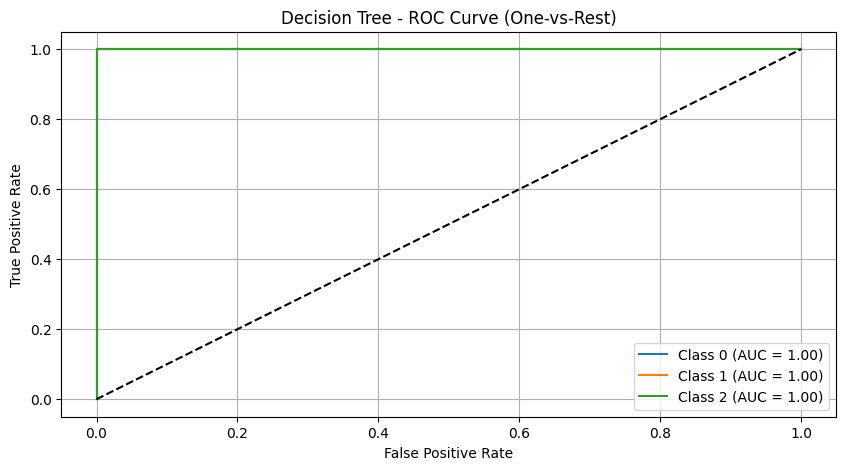

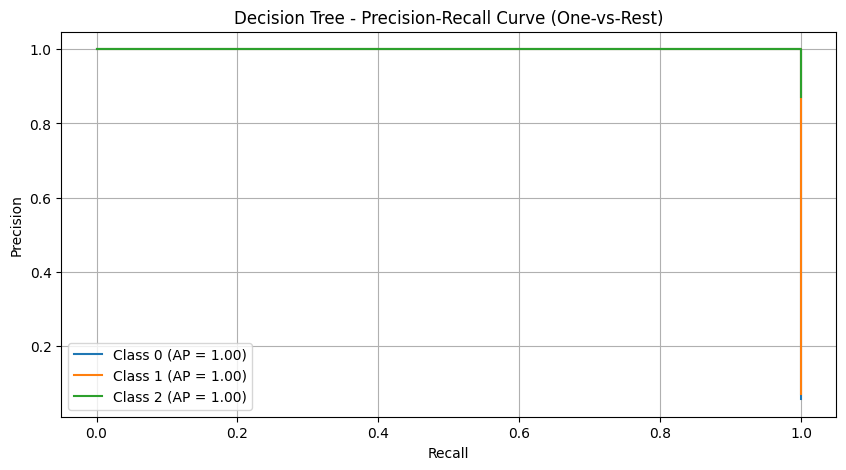


Extra Trees Test Classification Report:
              precision    recall  f1-score   support

           0     0.9842    1.0000    0.9920       187
           1     1.0000    0.9869    0.9934       229
           2     1.0000    1.0000    1.0000      2848

    accuracy                         0.9991      3264
   macro avg     0.9947    0.9956    0.9951      3264
weighted avg     0.9991    0.9991    0.9991      3264

Extra Trees Inference Time (Test Set): 0.0810 seconds
Extra Trees Confusion Matrix:
[[ 187    0    0]
 [   3  226    0]
 [   0    0 2848]]
Extra Trees Macro ROC AUC: 1.0000
Extra Trees Macro PR AUC: 1.0000


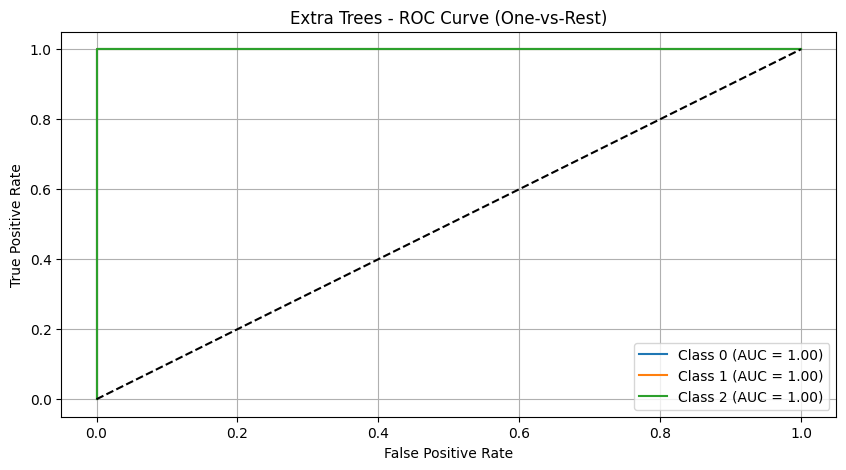

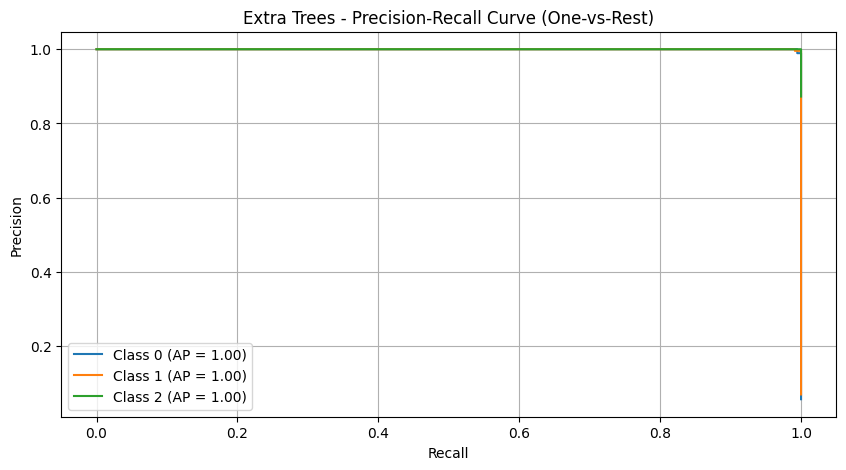


KNN Test Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       187
           1     1.0000    1.0000    1.0000       229
           2     1.0000    1.0000    1.0000      2848

    accuracy                         1.0000      3264
   macro avg     1.0000    1.0000    1.0000      3264
weighted avg     1.0000    1.0000    1.0000      3264

KNN Inference Time (Test Set): 0.4244 seconds
KNN Confusion Matrix:
[[ 187    0    0]
 [   0  229    0]
 [   0    0 2848]]
KNN Macro ROC AUC: 1.0000
KNN Macro PR AUC: 1.0000


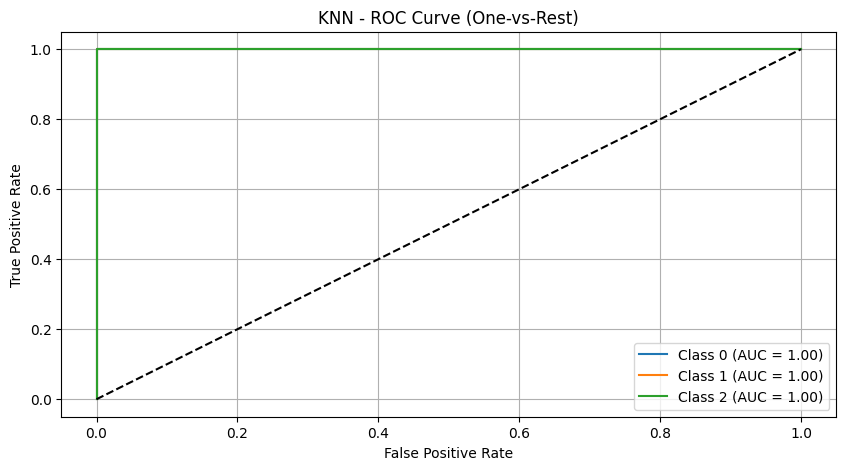

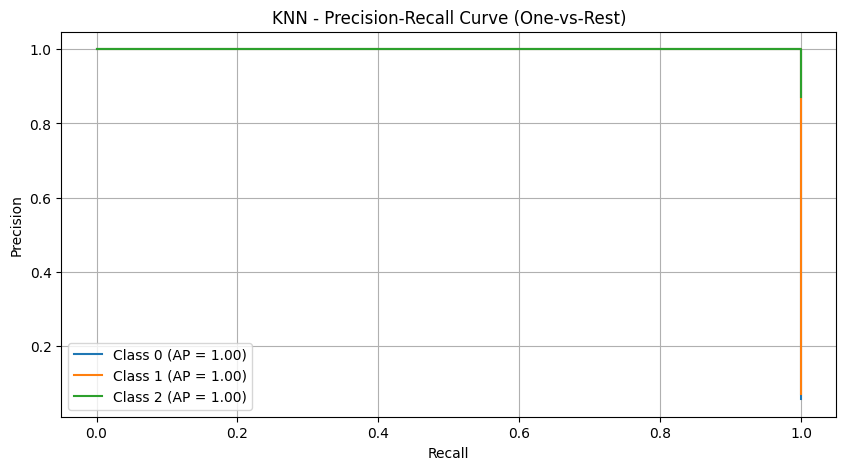


MLP Test Classification Report:
              precision    recall  f1-score   support

           0     0.9947    1.0000    0.9973       187
           1     1.0000    0.9956    0.9978       229
           2     1.0000    1.0000    1.0000      2848

    accuracy                         0.9997      3264
   macro avg     0.9982    0.9985    0.9984      3264
weighted avg     0.9997    0.9997    0.9997      3264

MLP Inference Time (Test Set): 0.0285 seconds
MLP Confusion Matrix:
[[ 187    0    0]
 [   1  228    0]
 [   0    0 2848]]
MLP Macro ROC AUC: 1.0000
MLP Macro PR AUC: 1.0000


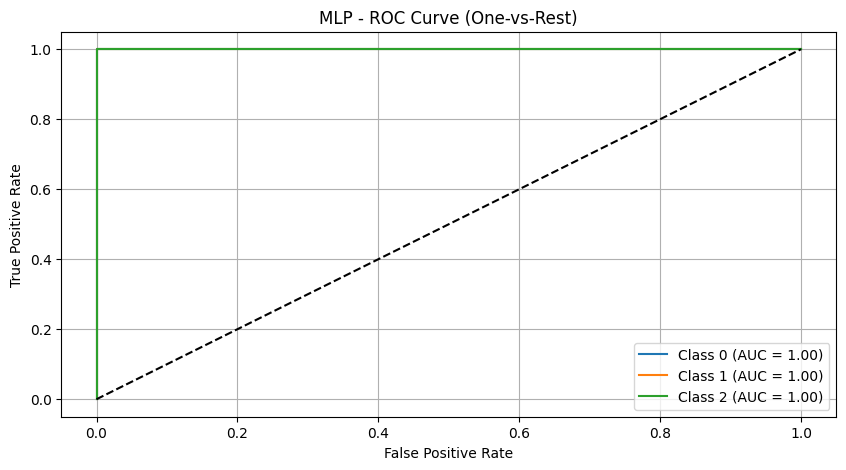

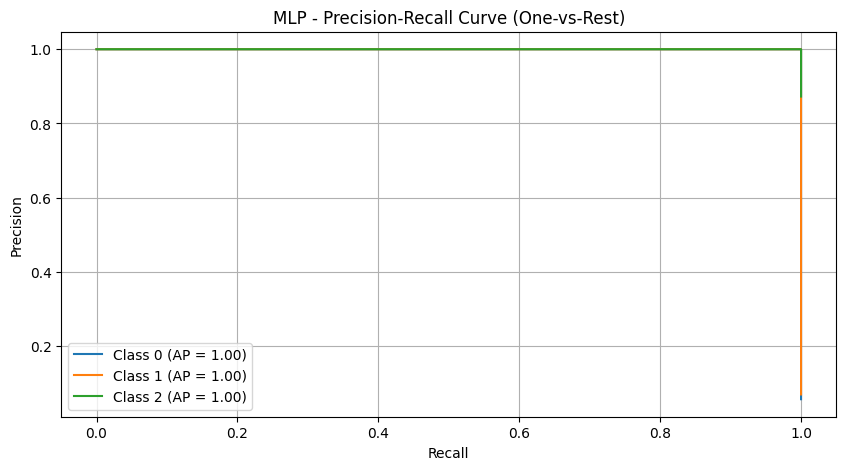


SVC Test Classification Report:
              precision    recall  f1-score   support

           0     0.9842    1.0000    0.9920       187
           1     1.0000    0.9869    0.9934       229
           2     1.0000    1.0000    1.0000      2848

    accuracy                         0.9991      3264
   macro avg     0.9947    0.9956    0.9951      3264
weighted avg     0.9991    0.9991    0.9991      3264

SVC Inference Time (Test Set): 1.1487 seconds
SVC Confusion Matrix:
[[ 187    0    0]
 [   3  226    0]
 [   0    0 2848]]
SVC Macro ROC AUC: 0.9998
SVC Macro PR AUC: 0.9977


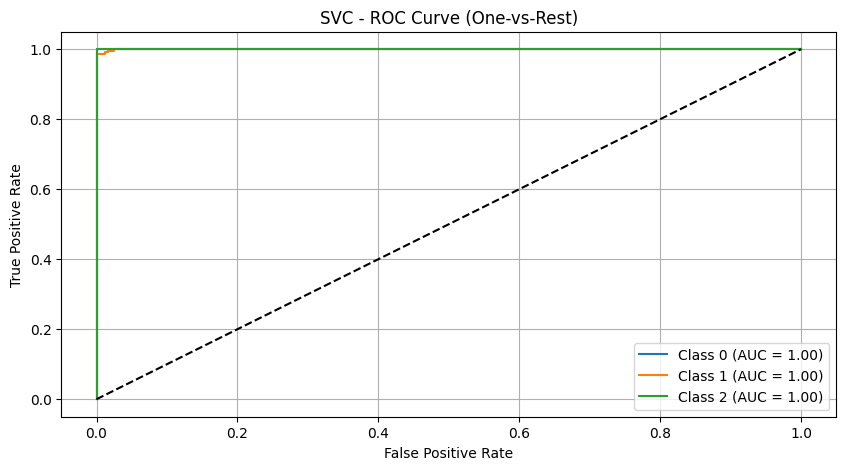

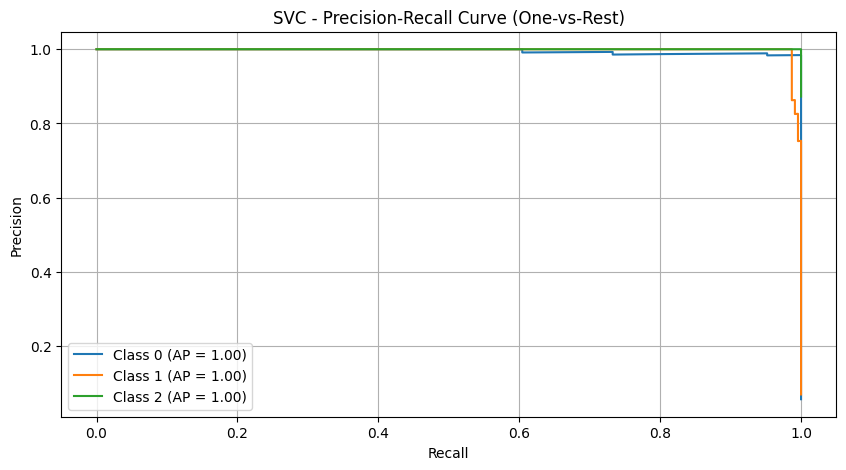


CatBoost Test Classification Report:
              precision    recall  f1-score   support

           0     0.9947    1.0000    0.9973       187
           1     1.0000    0.9956    0.9978       229
           2     1.0000    1.0000    1.0000      2848

    accuracy                         0.9997      3264
   macro avg     0.9982    0.9985    0.9984      3264
weighted avg     0.9997    0.9997    0.9997      3264

CatBoost Inference Time (Test Set): 0.0397 seconds
CatBoost Confusion Matrix:
[[ 187    0    0]
 [   1  228    0]
 [   0    0 2848]]
CatBoost Macro ROC AUC: 1.0000
CatBoost Macro PR AUC: 1.0000


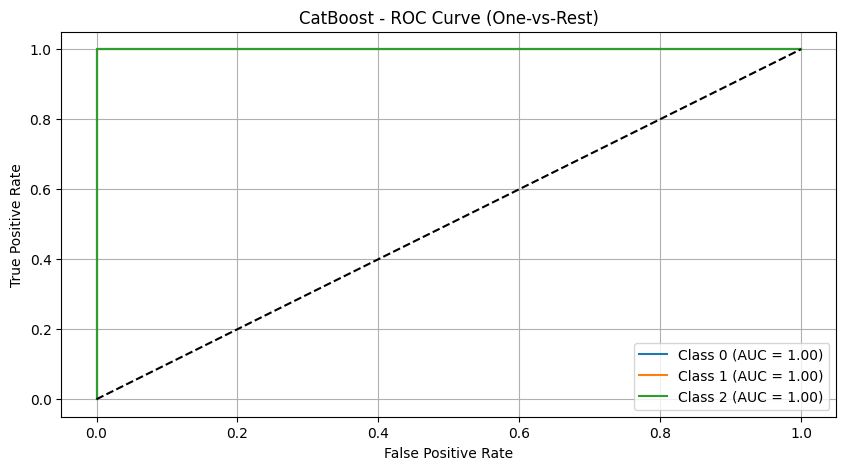

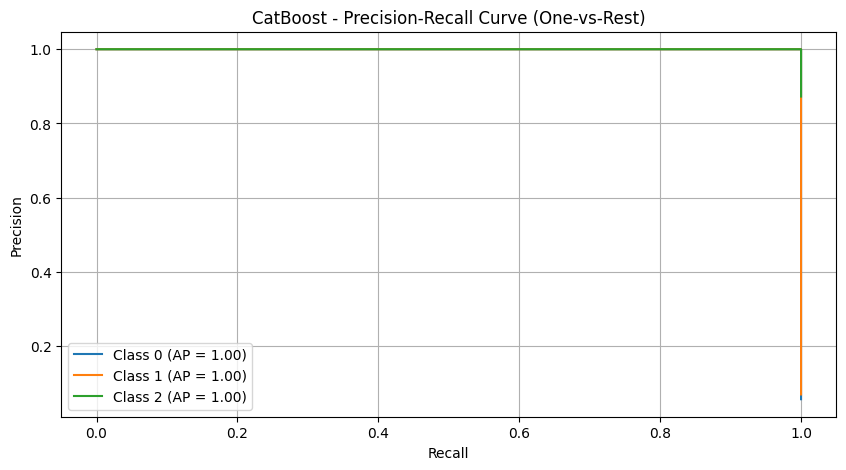


XGBoost Test Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       187
           1     1.0000    1.0000    1.0000       229
           2     1.0000    1.0000    1.0000      2848

    accuracy                         1.0000      3264
   macro avg     1.0000    1.0000    1.0000      3264
weighted avg     1.0000    1.0000    1.0000      3264

XGBoost Inference Time (Test Set): 0.1395 seconds
XGBoost Confusion Matrix:
[[ 187    0    0]
 [   0  229    0]
 [   0    0 2848]]
XGBoost Macro ROC AUC: 1.0000
XGBoost Macro PR AUC: 1.0000


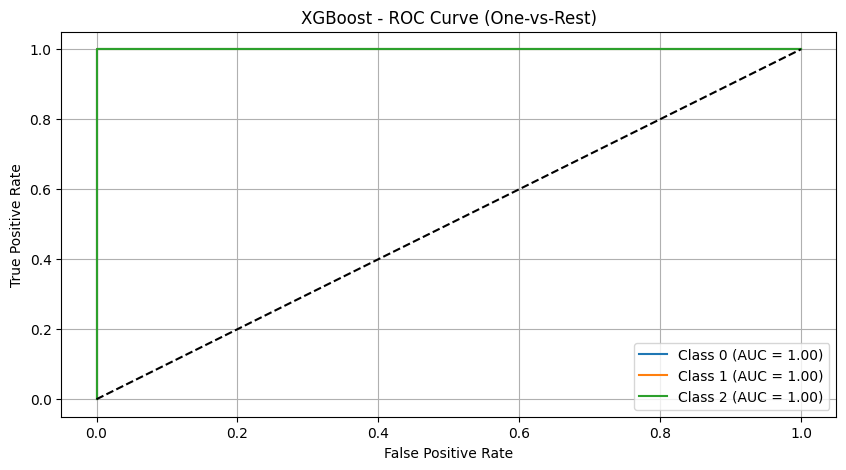

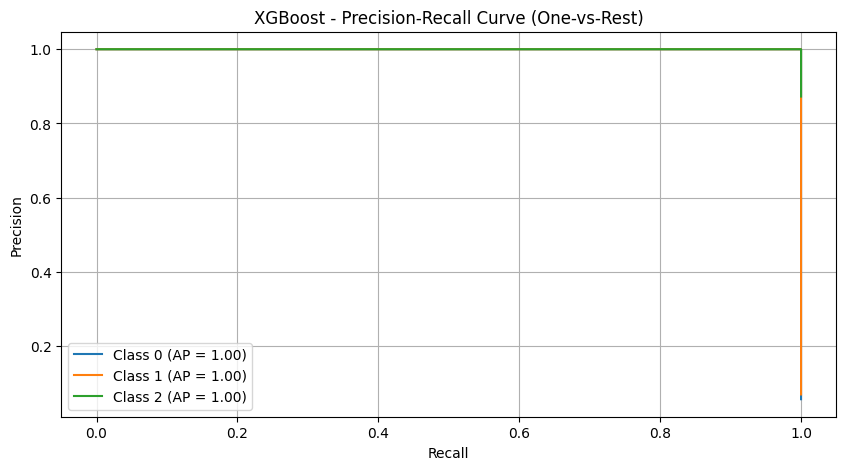

In [33]:
import time
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

X_test = test_df.drop(columns=['Attack Category'])
y_test = test_df['Attack Category']

classes = sorted(y_clean.unique())
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

for clf_name, clf in classifiers.items():
    start_infer = time.time()
    y_pred = clf.predict(X_test)
    end_infer = time.time()

    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
        if len(y_score.shape) == 1:
            y_score = np.vstack([1 - y_score, y_score]).T
    else:
        y_score = None

    print(f"\n{clf_name} Test Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    print(f"{clf_name} Inference Time (Test Set): {end_infer - start_infer:.4f} seconds")

    cm = confusion_matrix(y_test, y_pred)
    print(f"{clf_name} Confusion Matrix:")
    print(cm)

    if y_score is not None:
        try:
            roc_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
            print(f"{clf_name} Macro ROC AUC: {roc_auc:.4f}")
        except:
            pass

        try:
            pr_auc = average_precision_score(y_test_bin, y_score, average="macro")
            print(f"{clf_name} Macro PR AUC: {pr_auc:.4f}")
        except:
            pass

        plt.figure(figsize=(10, 5))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc_score(y_test_bin[:, i], y_score[:, i]):.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{clf_name} - ROC Curve (One-vs-Rest)')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 5))
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            plt.plot(recall, precision, label=f"Class {classes[i]} (AP = {average_precision_score(y_test_bin[:, i], y_score[:, i]):.2f})")
        plt.title(f'{clf_name} - Precision-Recall Curve (One-vs-Rest)')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.show()

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:35:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


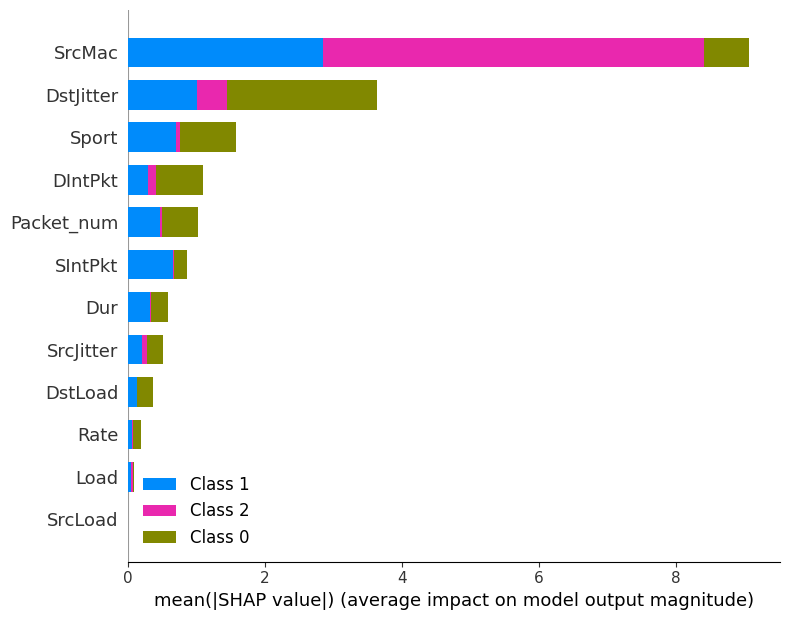

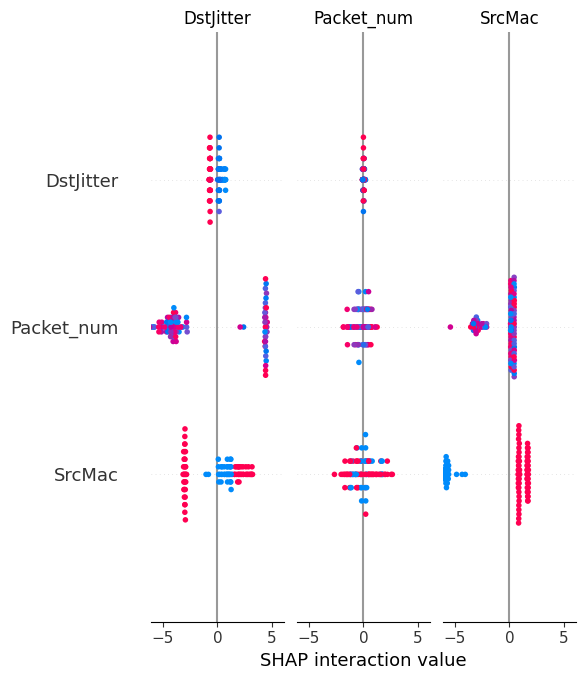

In [34]:
import time
import shap
import numpy as np
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

X_clean = train_df_balanced.drop(columns=['Attack Category'])
y_clean = train_df_balanced['Attack Category']

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

print("Training XGBoost...")
start_time = time.time()
xgb_clf.fit(X_clean, y_clean)
end_time = time.time()

y_train_pred = xgb_clf.predict(X_clean)



explainer = shap.TreeExplainer(xgb_clf)

X_sample = X_clean.sample(100, random_state=42)
shap_values = explainer.shap_values(X_sample)


shap.summary_plot(shap_values, X_sample, plot_type="bar")

shap.summary_plot(shap_values, X_sample)


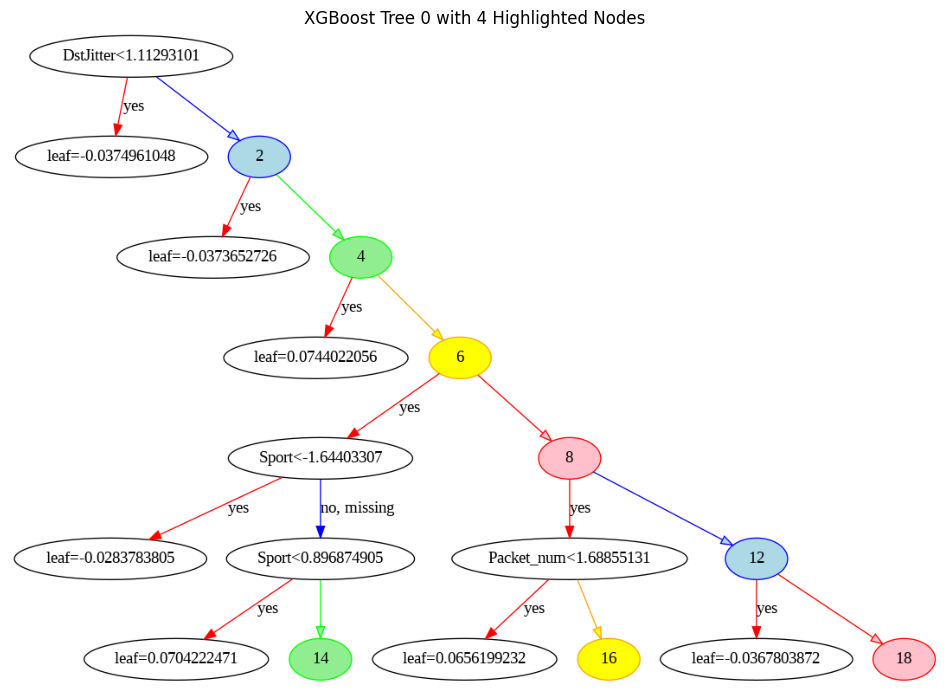

In [35]:
import xgboost as xgb
from graphviz import Source
import matplotlib.pyplot as plt
from PIL import Image
import re

highlight_nodes = {
    2: {'fillcolor': 'lightblue', 'style': 'filled', 'color': 'blue', 'fontcolor': 'black'},
    4: {'fillcolor': 'lightgreen', 'style': 'filled', 'color': 'green', 'fontcolor': 'black'},
    6: {'fillcolor': 'yellow', 'style': 'filled', 'color': 'orange', 'fontcolor': 'black'},
    8: {'fillcolor': 'pink', 'style': 'filled', 'color': 'red', 'fontcolor': 'black'},
}


dot_data = xgb.to_graphviz(xgb_clf, num_trees=0)
dot_str = dot_data.source

def make_node_style_str(node_id, props):
    return f"{node_id} [fillcolor={props['fillcolor']}, style={props['style']}, color={props['color']}, fontcolor={props['fontcolor']}]"


for node_id, style_props in highlight_nodes.items():

    pattern = rf"{node_id} \[.*?\]"
    replacement = make_node_style_str(node_id, style_props)
    dot_str = re.sub(pattern, replacement, dot_str)

highlighted_graph = Source(dot_str)
highlighted_graph.render("xgb_tree_4nodes_highlighted", format="png")

img = Image.open("xgb_tree_4nodes_highlighted.png")
plt.figure(figsize=(12, 20))
plt.imshow(img)
plt.axis('off')
plt.title("XGBoost Tree 0 with 4 Highlighted Nodes")
plt.show()


Permutation Feature Importance:
       Feature  Importance Mean  Importance Std
0       SrcMac         0.223591        0.003811
1    DstJitter         0.050705        0.001358
2   Packet_num         0.005576        0.001086
3        Sport         0.005545        0.001274
4      DstLoad         0.001869        0.000398
5    SrcJitter         0.000276        0.000092
6      DIntPkt         0.000000        0.000000
7         Load         0.000000        0.000000
8      SrcLoad         0.000000        0.000000
9         Rate         0.000000        0.000000
10     SIntPkt         0.000000        0.000000
11         Dur         0.000000        0.000000


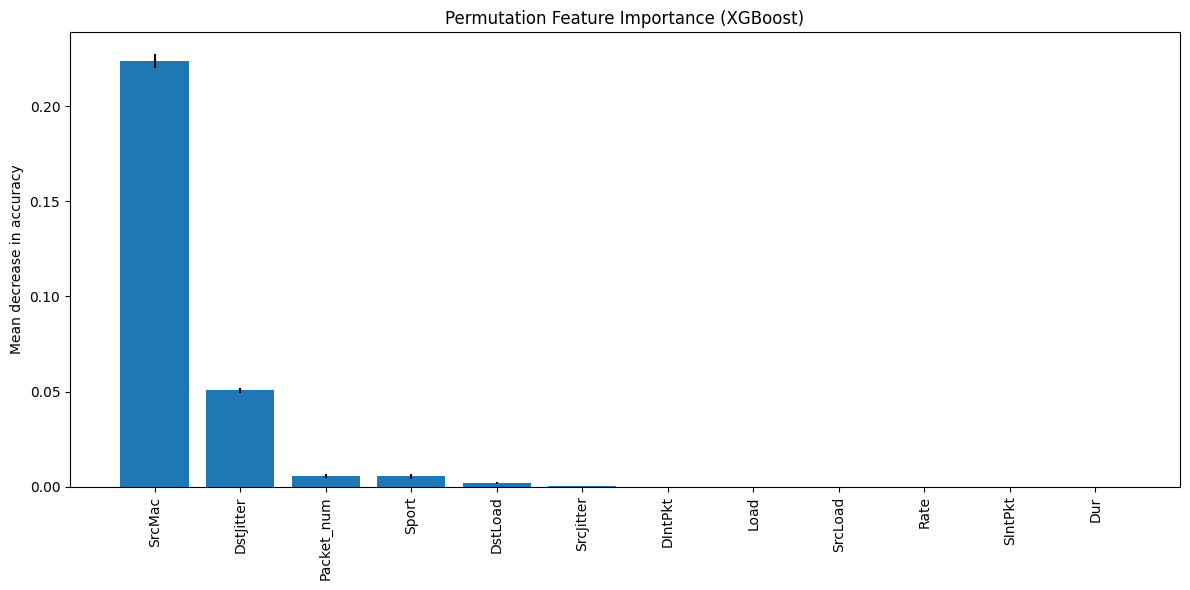

In [36]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

result = permutation_importance(
    xgb_clf, X_test, y_test,
    n_repeats=10, random_state=42, scoring='accuracy'
)

importances = result.importances_mean
stds = result.importances_std
features = X_test.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance Mean': importances,
    'Importance Std': stds
})


importance_df = importance_df.sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)

print("Permutation Feature Importance:")
print(importance_df)


plt.figure(figsize=(12, 6))
plt.title("Permutation Feature Importance (XGBoost)")
plt.bar(importance_df['Feature'], importance_df['Importance Mean'], yerr=importance_df['Importance Std'], align="center")
plt.xticks(rotation=90)
plt.ylabel("Mean decrease in accuracy")
plt.tight_layout()
plt.show()
